In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df= pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv")

In [5]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (100000, 31)
Columns: ['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score', 'diabetes_stage', 'diagnosed_diabetes']
   age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Re

In [6]:

df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [7]:
print("Missing values per column:\n", df.isnull().sum())
df = df.dropna()

Missing values per column:
 age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fast

In [8]:
df.columns = df.columns.str.strip().str.lower()

In [9]:
symptom_cols = ['glucose_fasting','glucose_postprandial', 'hba1c', 'heart_rate', 'insulin_level']
symptom_cols = [c for c in symptom_cols if c in df.columns]

cause_df = df.drop(columns=symptom_cols, errors='ignore')


In [10]:
print("Unique values:\n", df['diabetes_stage'].unique())
df['diabetes_stage'] = df['diabetes_stage'].str.strip().str.lower()
stage_map = {
    'no diabetes': 0,
    'gestational': 1,
    'pre-diabetes': 2,
    'type 1': 3,
    'type 2': 4
}
df['diabetes_stage'] = df['diabetes_stage'].map(stage_map)
print("Mapped diabetes_stage values:\n", df['diabetes_stage'].unique())

Unique values:
 ['Type 2' 'No Diabetes' 'Pre-Diabetes' 'Gestational' 'Type 1']
Mapped diabetes_stage values:
 [4 0 2 1 3]


In [11]:
target = 'diabetes_stage'
drop_target = cause_df.drop(columns=[target], errors='ignore')
add_target_num = df[target]

drop_target_encoded = pd.get_dummies(drop_target, drop_first=True)

corr_df = drop_target_encoded.copy()
corr_df[target] = add_target_num

corr = corr_df.corr()

target_corr = corr[target].sort_values(ascending=False)
print("Top correlations with diabetes_stage:")
print(target_corr.head(20))
print("\nLowest correlations (negative impact):")
print(target_corr.tail(10))

Top correlations with diabetes_stage:
diabetes_stage               1.000000
diagnosed_diabetes           0.913685
diabetes_risk_score          0.298276
family_history_diabetes      0.203137
age                          0.155731
bmi                          0.108363
systolic_bp                  0.105785
waist_to_hip_ratio           0.087845
ldl_cholesterol              0.075981
cholesterol_total            0.066770
triglycerides                0.062694
diastolic_bp                 0.043224
cardiovascular_history       0.031428
hypertension_history         0.030669
screen_time_hours_per_day    0.022117
gender_Male                  0.006080
income_level_Lower-Middle    0.004374
gender_Other                 0.003940
ethnicity_Other              0.002202
education_level_No formal    0.002129
Name: diabetes_stage, dtype: float64

Lowest correlations (negative impact):
smoking_status_Never                 -0.000677
sleep_hours_per_day                  -0.000974
employment_status_Student      

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


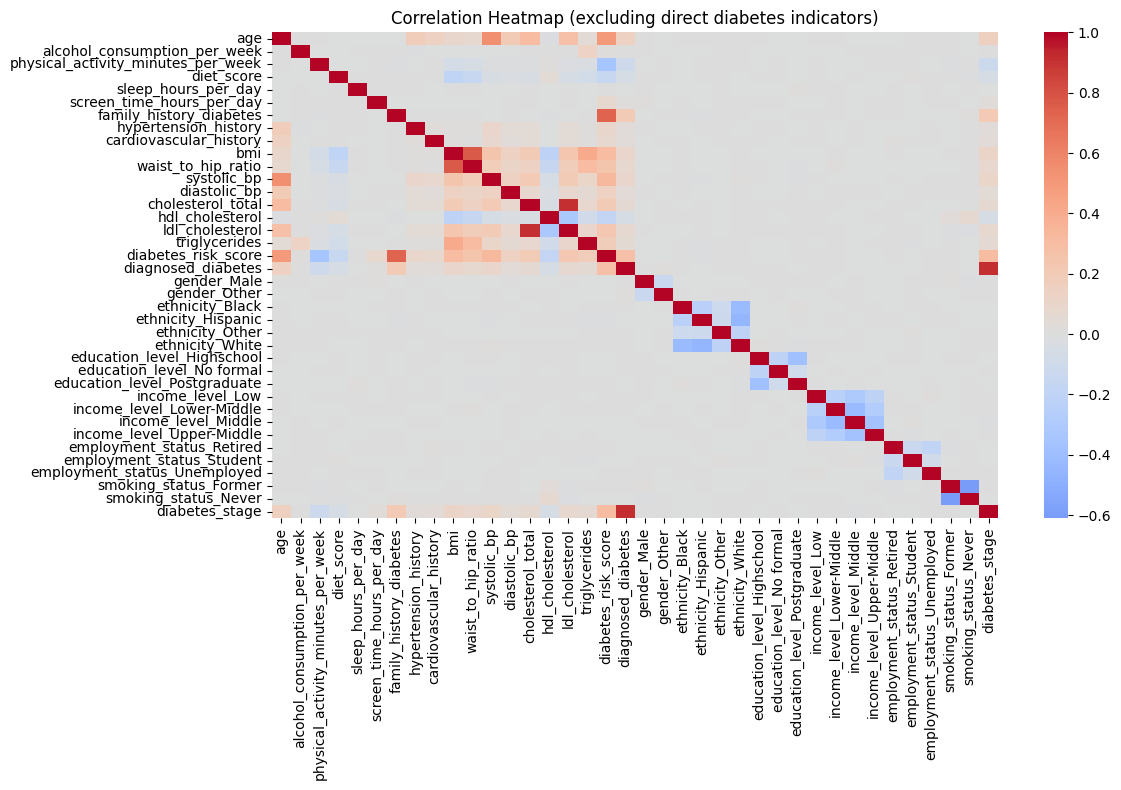

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (excluding direct diabetes indicators)')
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

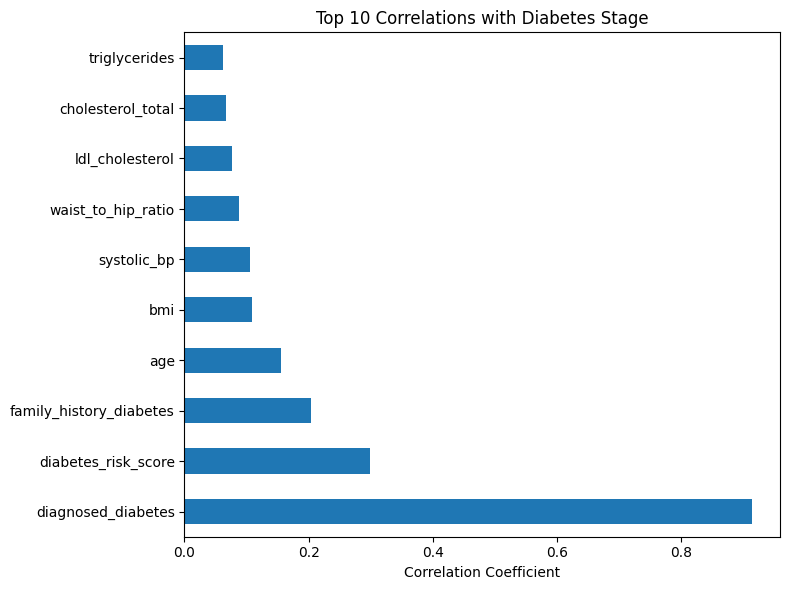

In [13]:
plt.figure(figsize=(8,6))
target_corr.drop(index='diabetes_stage').nlargest(10).plot(kind='barh')
plt.title('Top 10 Correlations with Diabetes Stage')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig("top10_correlations.png")
plt.show()

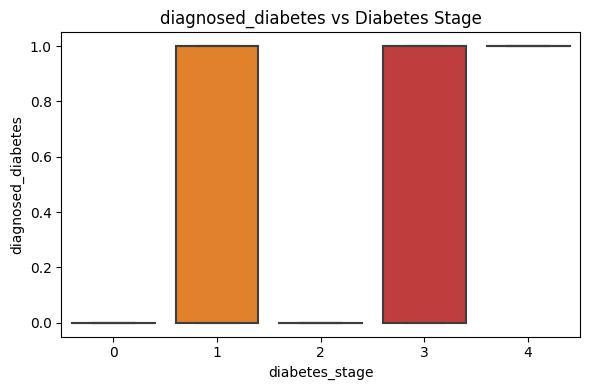

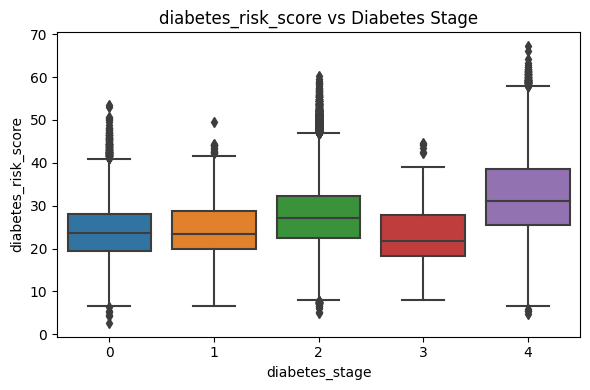

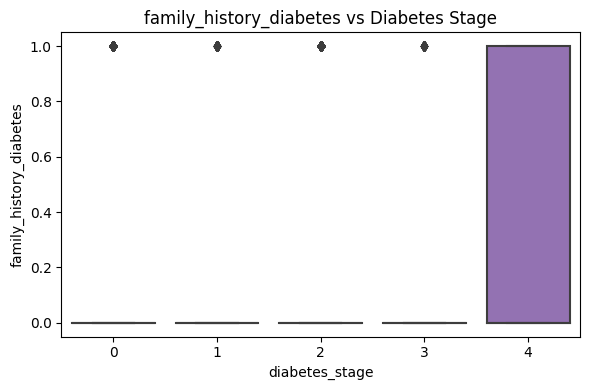

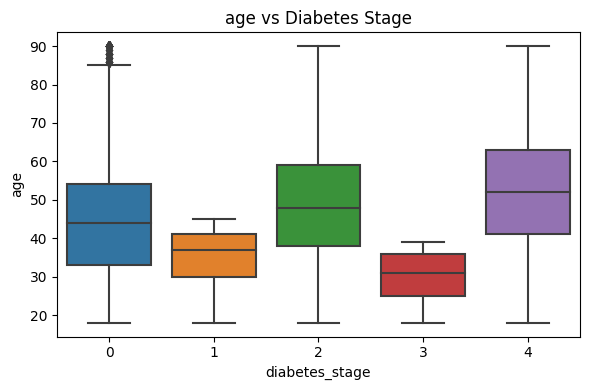

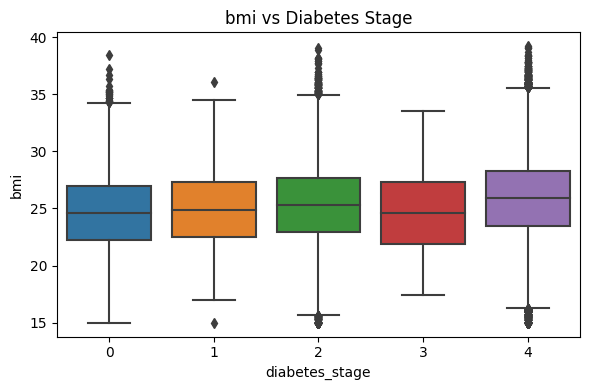

In [20]:
top_features = target_corr.drop(index='diabetes_stage').nlargest(5).index.tolist()

for col in top_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='diabetes_stage', y=col, data=pd.concat([add_target_num, drop_target], axis=1))
    plt.title(f'{col} vs Diabetes Stage')
    plt.tight_layout()
    filename = f"{col}_vs_diabetes_stage.png".replace(" ", "_").lower()
    plt.savefig(filename)
    plt.show()

In [21]:

from sklearn.model_selection import train_test_split
causal_features = [
    'age', 'bmi', 'family_history_diabetes',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp',
    'hypertension_history', 'cardiovascular_history',
    'physical_activity_minutes_per_week', 'diet_score',
    'sleep_hours_per_day'
]

causal_features = [c for c in causal_features if c in df.columns]

X = df[causal_features]
y = df['diabetes_stage']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 0.60125
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.00      0.00      1596
           1       0.00      0.00      0.00        56
           2       0.41      0.09      0.15      6369
           3       0.00      0.00      0.00        24
           4       0.62      0.96      0.75     11955

    accuracy                           0.60     20000
   macro avg       0.27      0.21      0.18     20000
weighted avg       0.52      0.60      0.50     20000

Confusion Matrix:
 [[    4     0   310     0  1282]
 [    0     0    12     0    44]
 [    7     0   600     0  5762]
 [    0     0     8     0    16]
 [    2     0   532     0 11421]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("\n=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


=== Decision Tree ===
Accuracy: 0.48525
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.11      0.11      1596
           1       0.00      0.00      0.00        56
           2       0.34      0.35      0.34      6369
           3       0.00      0.00      0.00        24
           4       0.63      0.61      0.62     11955

    accuracy                           0.49     20000
   macro avg       0.21      0.21      0.21     20000
weighted avg       0.49      0.49      0.49     20000

Confusion Matrix:
 [[ 176    7  623    3  787]
 [   5    0   18    0   33]
 [ 648   21 2250   11 3439]
 [   3    1   10    0   10]
 [ 853   21 3792   10 7279]]


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.59055
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.01      0.01      1596
           1       0.00      0.00      0.00        56
           2       0.39      0.16      0.22      6369
           3       0.00      0.00      0.00        24
           4       0.62      0.90      0.74     11955

    accuracy                           0.59     20000
   macro avg       0.24      0.21      0.19     20000
weighted avg       0.51      0.59      0.51     20000

Confusion Matrix:
 [[    8     0   416     0  1172]
 [    0     0    16     0    40]
 [   22     0  1001     0  5346]
 [    0     0    11     0    13]
 [   12     0  1141     0 10802]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
y_pred_cat = catboost_model.predict(X_test)

print("\n=== CatBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Classification Report:\n", classification_report(y_test, y_pred_cat))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))


=== CatBoost ===
Accuracy: 0.59765
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.01      0.02      1596
           1       0.00      0.00      0.00        56
           2       0.41      0.12      0.19      6369
           3       0.00      0.00      0.00        24
           4       0.62      0.93      0.74     11955

    accuracy                           0.60     20000
   macro avg       0.25      0.21      0.19     20000
weighted avg       0.52      0.60      0.51     20000

Confusion Matrix:
 [[   14     0   331     0  1251]
 [    0     0    13     0    43]
 [   26     0   782     0  5561]
 [    1     0     7     0    16]
 [   16     0   782     0 11157]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
